In [2]:
import os
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np
import pandas as pd
import math
from tqdm import tqdm
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from skimage.feature import graycomatrix, graycoprops
from scipy.stats import entropy
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay)
from sklearn.decomposition import PCA
import seaborn as sns
from rembg import remove


In [3]:
def resize_image(image, target_size):
    height, width, _ = image.shape
    target_width, target_height = target_size
    resized_image = np.zeros((target_height, target_width, 3), dtype=np.uint8)

    for i in range(target_height):
        for j in range(target_width):
            original_x = int(j * width / target_width)
            original_y = int(i * height / target_height)
            resized_image[i, j] = image[original_y, original_x]

    return resized_image

In [4]:
def insertGambar(folder):
    data = []
    filenames = []
    datalabel = []
    path = []
    data_distribution = {}
    datakategori = {}

    for label in os.listdir(folder):
        folder_path = os.path.join(folder, label)
        images = os.listdir(folder_path)
        data_distribution[label] = len(images)
        datalabel.append(label)
        print(f"Loading kategori: {label}")
        
        kategori_data = []

        for filename in tqdm(images):
            img_path = os.path.join(folder_path, filename)
            img = cv.imread(img_path)
            if img is not None:
                img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
                img = resize_image(img, (100, 100))
                filenames.append(filename)
                path.append(label)
                data.append(img)
                kategori_data.append((filename, img))

        datakategori[label] = kategori_data

    return data, filenames, datalabel, path, data_distribution, datakategori

In [5]:

data, filenames, label, path, distribusi, datakategori = insertGambar("Dataset/")
print("Total Data:", len(data))
print("Label unik:", label)
print("Distribusi data:", distribusi)


Loading kategori: Agaricus_bisporus


100%|██████████| 53/53 [00:00<00:00, 125.41it/s]


Loading kategori: Agaricus_hondensis


100%|██████████| 51/51 [00:00<00:00, 138.34it/s]

Total Data: 104
Label unik: ['Agaricus_bisporus', 'Agaricus_hondensis']
Distribusi data: {'Agaricus_bisporus': 53, 'Agaricus_hondensis': 51}


In [6]:
def display_sample(datakategori):
    for kategori, data in datakategori.items():
        print(f"Menampilkan sample untuk kategori: {kategori}")
        images = [img for _, img in data]
        plt.figure(figsize=(20, 3))
        for i in range(min(7, len(images))):
            plt.subplot(1, 7, i+1)
            plt.xticks([])
            plt.yticks([])
            plt.grid(False)
            if len(images[i].shape) == 2:  # grayscale
                plt.imshow(images[i], cmap='gray')
            else:
                plt.imshow(images[i])
        plt.suptitle(f"Kategori: {kategori}")
        plt.show()

Menampilkan sample untuk kategori: Agaricus_bisporus


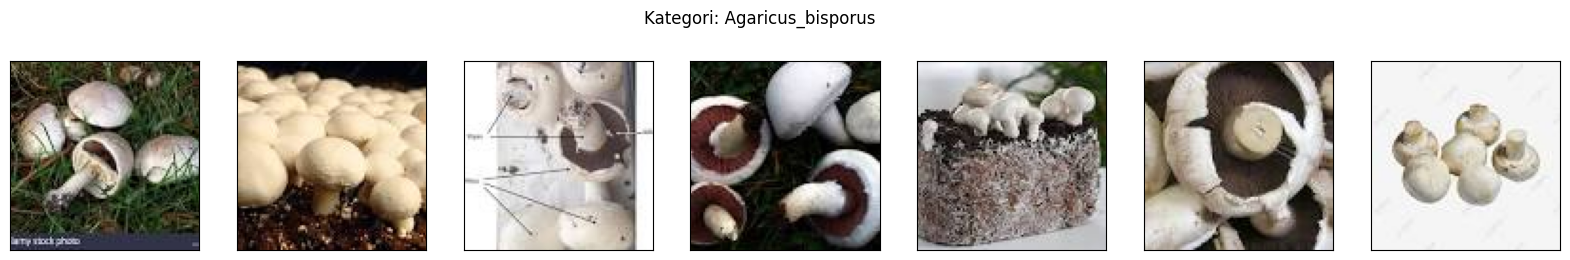

Menampilkan sample untuk kategori: Agaricus_hondensis


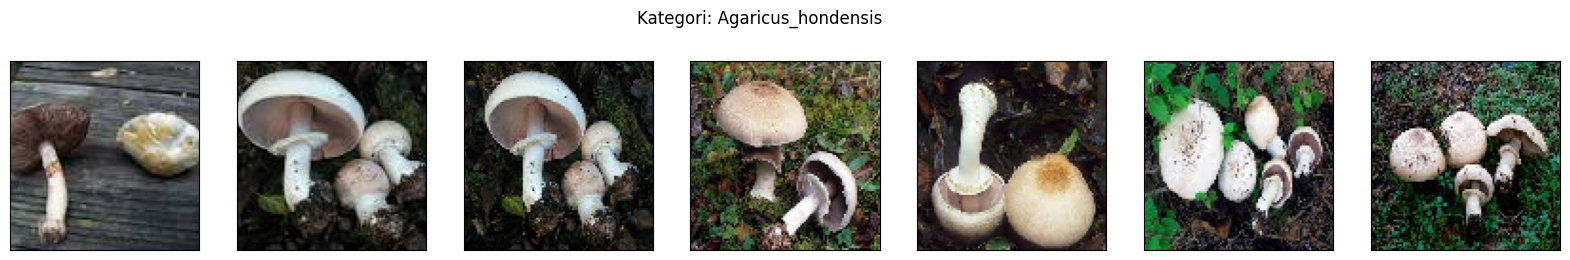

In [7]:
display_sample(datakategori)

In [15]:
def removeBackgroundByCategory(data):
    removed_data = {}

    for kategori, items in data.items():
        removed_list = []
        for filename, img in tqdm(items, desc=f"remove background {kategori}"):
            img_removed = remove(img) 
            removed_list.append((filename, img_removed))
        removed_data[kategori] = removed_list

    return removed_data


In [16]:
removej = removeBackgroundByCategory(datakategori)  # pertama remove background

def gray_scaling(data):
    gray_data = {}

    for kategori, items in data.items():
        gray_list = []
        for filename, img in tqdm(items, desc=f"grayscaling {kategori}"):
            gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
            gray_list.append((filename, gray))  
        gray_data[kategori] = gray_list

    return gray_data

grayj = gray_scaling(removej)  # kemudian grayscale


grayscaling Agaricus_hondensis: 100%|██████████| 51/51 [00:00<00:00, 21156.12it/s]


Menampilkan sample untuk kategori: Agaricus_bisporus


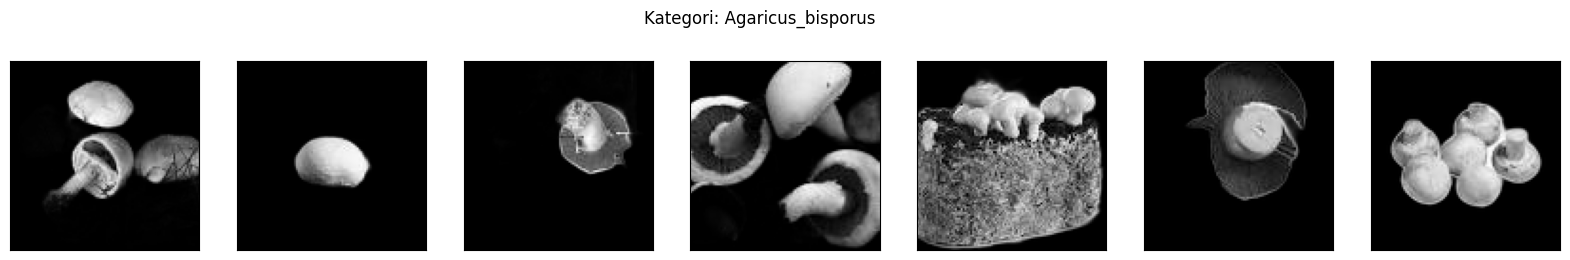

Menampilkan sample untuk kategori: Agaricus_hondensis


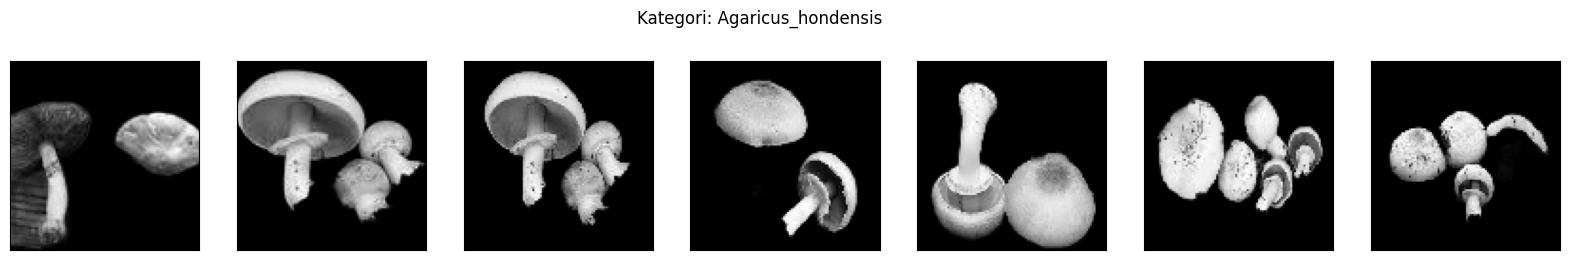

In [27]:
display_sample(grayj)

gray_images = []

for kategori in grayj:
    for filename, img in grayj[kategori]:
        gray_images.append(img)

Median Agaricus_bisporus:   0%|          | 0/53 [00:00<?, ?it/s]

Median Agaricus_hondensis: 100%|██████████| 51/51 [00:03<00:00, 13.13it/s]


Menampilkan sample untuk kategori: Agaricus_bisporus


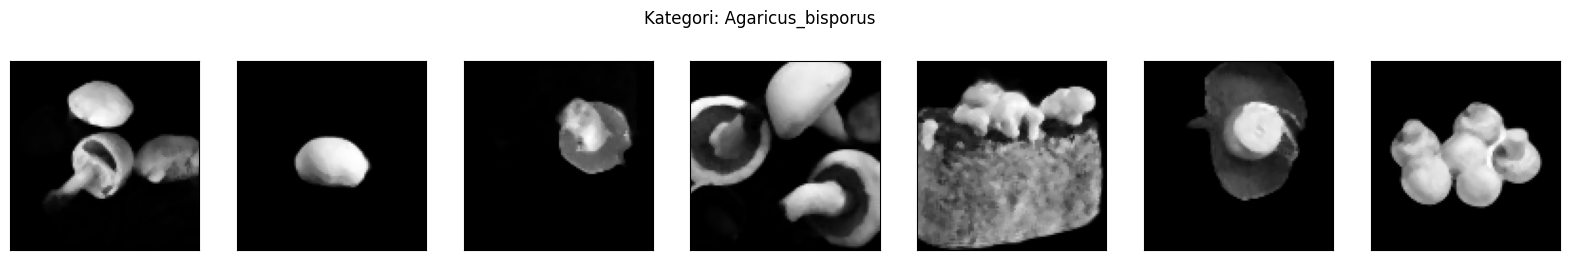

Menampilkan sample untuk kategori: Agaricus_hondensis


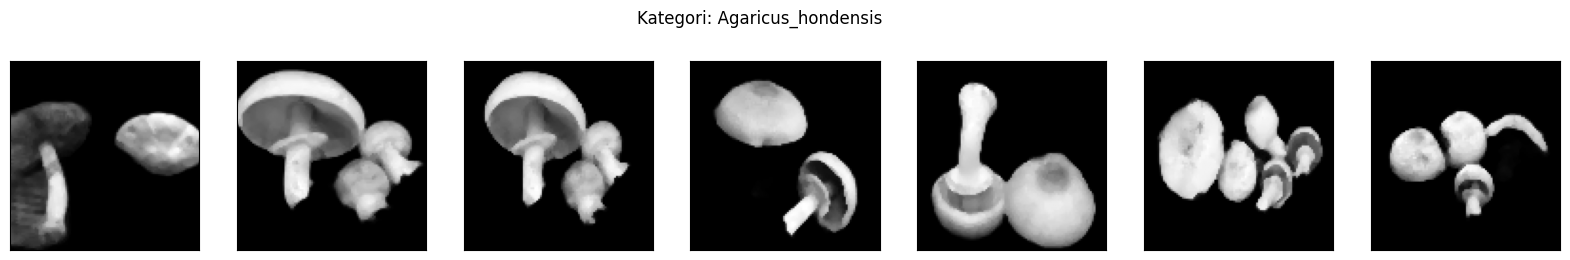

In [74]:
def median(image, ksize=3):
    assert ksize % 2 == 1
    pad = ksize // 2
    padded_img = np.pad(image, pad, mode='edge')
    h, w = image.shape
    filtered_img = np.zeros_like(image)

    for i in range(h):
        for j in range(w):
            window = []
            for m in range(-pad, pad + 1):
                for n in range(-pad, pad + 1):
                    val = padded_img[i + pad + m, j + pad + n]
                    window.append(int(val))

            window.sort()
            median_val = window[len(window) // 2]
            filtered_img[i, j] = median_val

    return filtered_img

def apply_manual_median_filter(data, ksize=3):
    filtered_data = {}

    for kategori, items in data.items():
        filtered_list = []
        for filename, img in tqdm(items, desc=f"Median {kategori}"):
            filtered_img = median(img, ksize)
            filtered_list.append((filename, filtered_img))
        filtered_data[kategori] = filtered_list

    return filtered_data

medianimg = apply_manual_median_filter(grayj)
display_sample(medianimg)

gray_images = []

for kategori in medianimg:
    for filename, img in medianimg[kategori]:
        gray_images.append(img)


In [75]:
def glcm(image, derajat):
    if derajat == 0:
        angles = [0]
    elif derajat == 45:
        angles = [np.pi / 4]
    elif derajat == 90:
        angles = [np.pi / 2]
    elif derajat == 135:
        angles = [3 * np.pi / 4]
    else:
        raise ValueError("Invalid angle. It should be one of the following: 0, 45, 90, 135.")
    glcm = graycomatrix(image, [1], angles, 256, symmetric=True, normed=True)
    return glcm

In [76]:
def correlation(matriks):
	return graycoprops(matriks, 'correlation')[0, 0]

In [77]:
def dissimilarity(matriks):
    return graycoprops(matriks, 'dissimilarity')[0, 0]

In [78]:
def homogenity(matriks):
    return graycoprops(matriks, 'homogeneity')[0, 0]

In [79]:
def contrast(matriks):
    return graycoprops(matriks, 'contrast')[0, 0]

In [80]:
def energy(matriks):
    return graycoprops(matriks, 'energy')[0, 0]

In [81]:
def ASM(matriks):
    return graycoprops(matriks, 'ASM')[0, 0]

In [82]:
def entropyGlcm(matriks):
    return entropy(matriks.ravel())

In [83]:
Derajat0 = []
Derajat45 = []
Derajat90 = []
Derajat135 = []
for i in range(len(gray_images)):
    D0 = glcm(gray_images[i], 0)
    D45 = glcm(gray_images[i], 45)
    D90 = glcm(gray_images[i], 90)
    D135 = glcm(gray_images[i], 135)
    Derajat0.append(D0)
    Derajat45.append(D45)
    Derajat90.append(D90)
    Derajat135.append(D135)

In [84]:
Kontras0, Kontras45, Kontras90, Kontras135 = [], [], [], []
dissimilarity0, dissimilarity45, dissimilarity90, dissimilarity135 =  [], [], [], []
homogenity0, homogenity45, homogenity90, homogenity135 = [], [], [], []
entropy0, entropy45, entropy90, entropy135 =  [], [], [], []
ASM0, ASM45, ASM90, ASM135 =  [], [], [], []
energy0, energy45, energy90, energy135 =  [], [], [], []
correlation0, correlation45, correlation90, correlation135 = [], [], [], []

In [85]:
for i in range(len(gray_images)):
    C0 = correlation(Derajat0[i])
    correlation0.append(C0)
    C45 = correlation(Derajat45[i])
    correlation45.append(C45)
    C90 = correlation(Derajat90[i])
    correlation90.append(C90)
    C135 = correlation(Derajat135[i])
    correlation135.append(C135)

In [86]:
for i in range(len(data)):
    K0 = contrast(Derajat0[i])
    K45 = contrast(Derajat45[i])
    K90 = contrast(Derajat90[i])
    K135 = contrast(Derajat135[i])
    Kontras0.append(K0)
    Kontras45.append(K45)
    Kontras90.append(K90)
    Kontras135.append(K135)

In [87]:
for i in range(len(data)):
    Dis0 = dissimilarity(Derajat0[i])
    Dis45 = dissimilarity(Derajat45[i])
    Dis90 = dissimilarity(Derajat90[i])
    Dis135 = dissimilarity(Derajat135[i])
    dissimilarity0.append(Dis0)
    dissimilarity45.append(Dis45)
    dissimilarity90.append(Dis90)
    dissimilarity135.append(Dis135)

In [88]:
for i in range(len(data)):
    H0 = homogenity(Derajat0[i])
    H45 = homogenity(Derajat45[i])
    H90 = homogenity(Derajat90[i])
    H135 = homogenity(Derajat135[i])
    homogenity0.append(H0)
    homogenity45.append(H45)
    homogenity90.append(H90)
    homogenity135.append(H135)

In [89]:
for i in range(len(data)):  
    E0 = entropyGlcm(Derajat0[i])
    E45 = entropyGlcm(Derajat45[i])
    E90 = entropyGlcm(Derajat90[i])
    E135 = entropyGlcm(Derajat135[i])
    entropy0.append(E0)
    entropy45.append(E45)
    entropy90.append(E90)
    entropy135.append(E135)

In [90]:
for i in range(len(data)):
    A0 = ASM(Derajat0[i])
    A45 = ASM(Derajat45[i])
    A90 = ASM(Derajat90[i])
    A135 = ASM(Derajat135[i])
    ASM0.append(A0)
    ASM45.append(A45)
    ASM90.append(A90)
    ASM135.append(A135)

In [91]:
for i in range(len(data)):
    ER0 = energy(Derajat0[i])
    ER45 = energy(Derajat45[i])
    ER90 = energy(Derajat90[i])
    ER135 = energy(Derajat135[i])
    energy0.append(ER0)
    energy45.append(ER45)
    energy90.append(ER90)
    energy135.append(ER135)

In [112]:
label = [1] * 100 + [0] * 100
dataTable = {'Filename': filenames, 'Label': path,
        'Contrast0': Kontras0, 'Contrast45': Kontras45, 'Contrast90': Kontras90, 'Contrast135': Kontras135,
        'Homogeneity0': homogenity0, 'Homogeneity45': homogenity45, 'Homogeneity90': homogenity90, 'Homogeneity135': homogenity135,
        'Dissimilarity0': dissimilarity0, 'Dissimilarity45': dissimilarity45, 'Dissimilarity90': dissimilarity90, 'Dissimilarity135': dissimilarity135,
        'Entropy0': entropy0, 'Entropy45': entropy45, 'Entropy90': entropy90, 'Entropy135': entropy135,
        'ASM0': ASM0, 'ASM45': ASM45, 'ASM90': ASM90, 'ASM135': ASM135,
        'Energy0': energy0, 'Energy45': energy45, 'Energy90': energy90, 'Energy135': energy135,
        'Correlation0': correlation0, 'Correlation45': correlation45, 'Correlation90': correlation90, 'Correlation135': correlation135,
        }
df = pd.DataFrame(dataTable)
df.to_csv('hasil_ekstraksi1.csv', index=False)

hasilEkstrak = pd.read_csv('hasil_ekstraksi1.csv')
hasilEkstrak


,Filename,Label,Contrast0,Contrast45,Contrast90,Contrast135,Homogeneity0,Homogeneity45,Homogeneity90,Homogeneity135,...,ASM90,ASM135,Energy0,Energy45,Energy90,Energy135,Correlation0,Correlation45,Correlation90,Correlation135
0,Agaricus_bisporus1.png,Agaricus_bisporus,199.018182,405.229058,254.141010,386.352209,0.724946,0.677068,0.703512,0.681084,...,0.205867,0.198208,0.460660,0.440257,0.453726,0.445205,0.974427,0.948308,0.967376,0.950716
1,Agaricus_bisporus12.png,Agaricus_bisporus,74.925051,147.436792,104.515960,170.326089,0.926676,0.922876,0.920909,0.912802,...,0.803135,0.799793,0.897895,0.894010,0.896178,0.894311,0.984501,0.969780,0.978379,0.965088
2,Agaricus_bisporus15.png,Agaricus_bisporus,36.137374,56.423018,39.222626,72.687889,0.868581,0.849652,0.875620,0.846267,...,0.492546,0.478542,0.699132,0.692899,0.701816,0.691767,0.980904,0.970446,0.979275,0.961926
3,Agaricus_bisporus18.png,Agaricus_bisporus,240.326364,740.247322,457.667172,510.180186,0.518452,0.451235,0.486445,0.460313,...,0.071625,0.069533,0.274567,0.255008,0.267629,0.263692,0.979762,0.937617,0.961400,0.957006
4,Agaricus_bisporus20.png,Agaricus_bisporus,347.041212,684.378941,397.467071,599.663912,0.401369,0.328739,0.395981,0.324016,...,0.037469,0.035284,0.198905,0.186518,0.193570,0.187839,0.957638,0.915835,0.951246,0.926253
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,Agaricus_hondensis50.png,Agaricus_hondensis,116.603838,200.731762,105.897778,179.896133,0.846535,0.824258,0.843747,0.820703,...,0.554968,0.545900,0.744859,0.738985,0.744962,0.738850,0.985661,0.975515,0.986977,0.978057
100,Agaricus_hondensis6.png,Agaricus_hondensis,128.692121,422.501581,386.365657,507.814917,0.800695,0.762453,0.772167,0.744678,...,0.391130,0.385388,0.631650,0.622455,0.625404,0.620796,0.993357,0.978300,0.980051,0.973918
101,Agaricus_hondensis7.png,Agaricus_hondensis,4.747677,17.042445,12.677071,15.961739,0.937866,0.920710,0.929913,0.921796,...,0.694210,0.681704,0.837112,0.826764,0.833193,0.825654,0.985109,0.947062,0.960296,0.950419
102,Agaricus_hondensis8.png,Agaricus_hondensis,254.204040,502.229772,175.733939,232.430976,0.857003,0.839260,0.868304,0.851082,...,0.614889,0.608063,0.780002,0.775378,0.784148,0.779784,0.976761,0.954097,0.983806,0.978756


<Axes: >

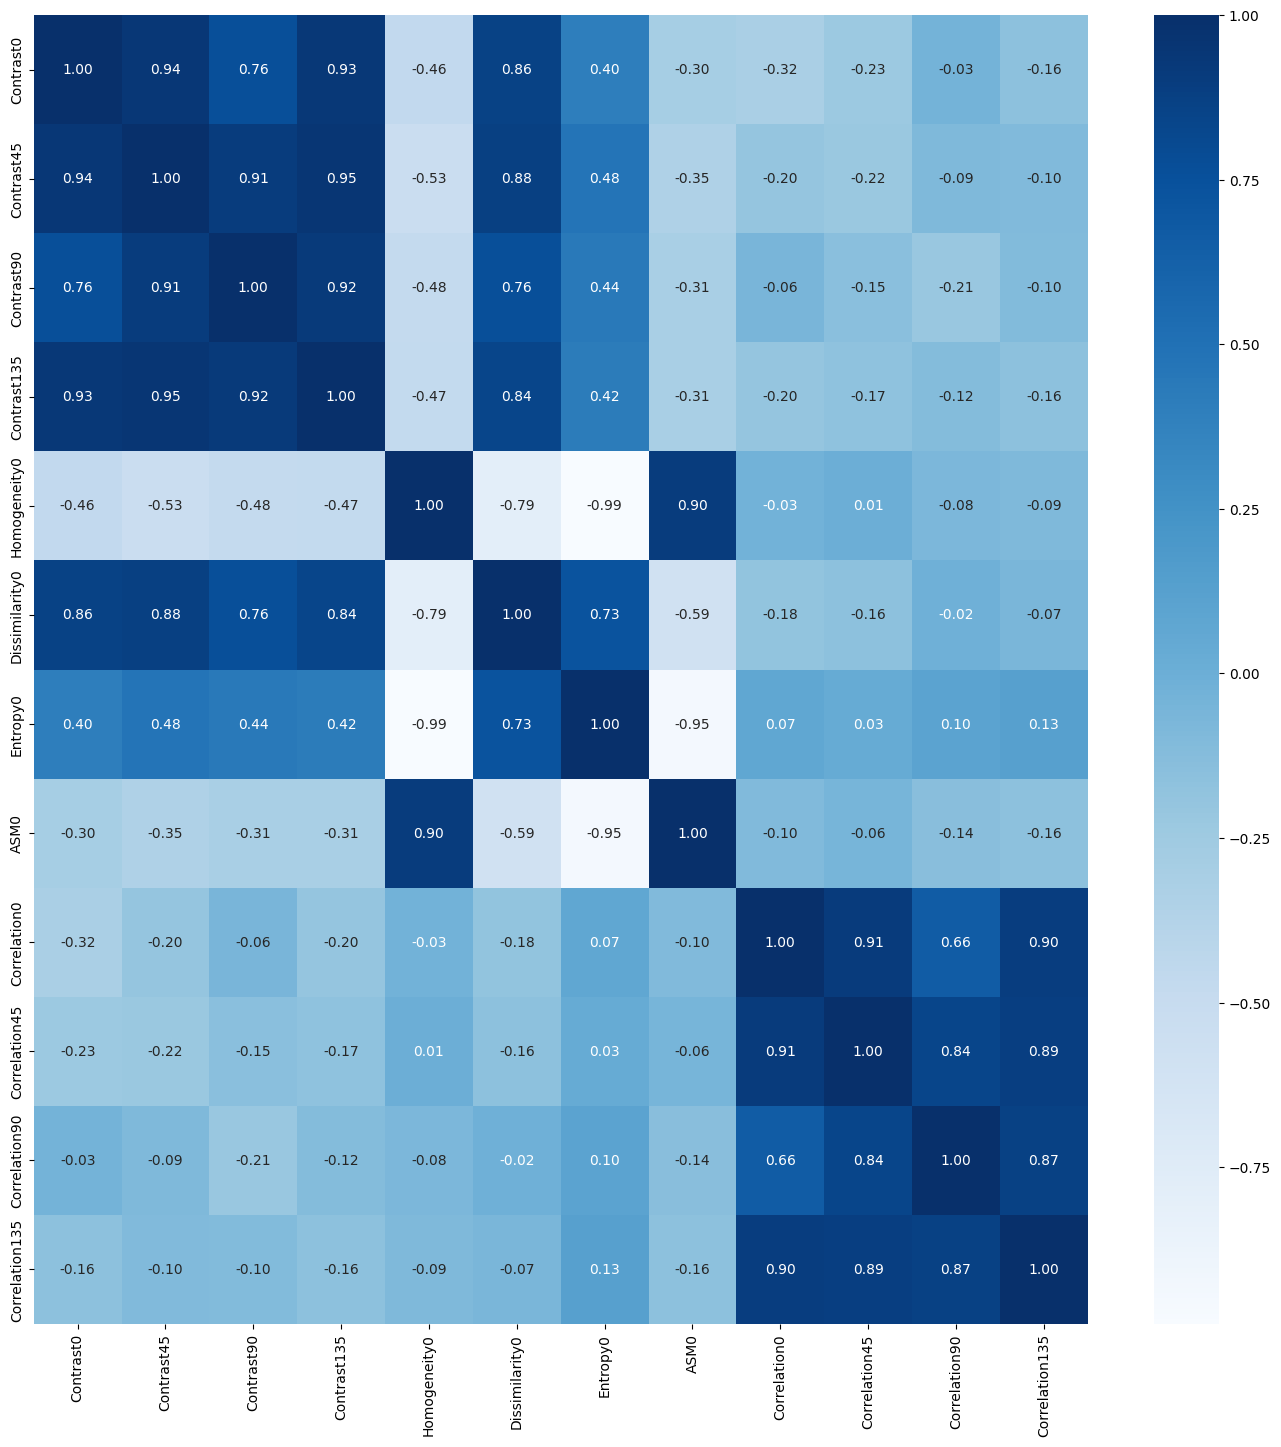

In [113]:
# Menghitung korelasi
correlation = hasilEkstrak.drop(columns=['Label','Filename']).corr()

# Menyaring fitur yang memiliki korelasi absolut lebih dari 0.95 dengan label
threshold = 0.95 # atur threshold ini untuk menentukan seberapa besar korelasi yang ingin disaring
selectionFeature = []
columns = np.full((correlation.shape[0],), True, dtype=bool)
for i in range(correlation.shape[0]):
	for j in range(i+1, correlation.shape[0]):
		if correlation.iloc[i,j] >= threshold:
			if columns[j]:
				columns[j] = False
select = hasilEkstrak.drop(columns=['Label','Filename']).columns[columns]
x_new = hasilEkstrak[select]
x_new
y = hasilEkstrak['Label']
plt.figure(figsize=(17,17))
sns.heatmap(x_new.corr(), annot=True, cmap='Blues', fmt=".2f")

In [114]:
X_train, X_test, y_train, y_test = train_test_split(x_new, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)

(83, 12)
(21, 12)


In [115]:
# normalisasi mean std
X_test = (X_test - X_train.mean()) / X_train.std()
X_train = (X_train - X_train.mean()) / X_train.std()

In [116]:
def generateClassificationReport(y_true, y_pred):
	print(classification_report(y_true, y_pred))
	print(confusion_matrix(y_true, y_pred))
	print('Accuracy:', accuracy_score(y_true, y_pred))

# Define classifiers
rf = RandomForestClassifier(n_estimators=5, random_state=42)
svm = SVC(kernel='rbf', random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)


In [117]:
# Train Random Forest Classifier
rf.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("------Training Set------")
y_pred = rf.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = rf.predict(X_test)
generateClassificationReport( y_test, y_pred)

------Training Set------
                    precision    recall  f1-score   support

 Agaricus_bisporus       0.91      0.93      0.92        42
Agaricus_hondensis       0.93      0.90      0.91        41

          accuracy                           0.92        83
         macro avg       0.92      0.92      0.92        83
      weighted avg       0.92      0.92      0.92        83

[[39  3]
 [ 4 37]]
Accuracy: 0.9156626506024096

------Testing Set------
                    precision    recall  f1-score   support

 Agaricus_bisporus       0.42      0.45      0.43        11
Agaricus_hondensis       0.33      0.30      0.32        10

          accuracy                           0.38        21
         macro avg       0.38      0.38      0.38        21
      weighted avg       0.38      0.38      0.38        21

[[5 6]
 [7 3]]
Accuracy: 0.38095238095238093


In [118]:
# Train SVM Classifier
svm.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = svm.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = svm.predict(X_test)
generateClassificationReport( y_test, y_pred)


------Training Set------
                    precision    recall  f1-score   support

 Agaricus_bisporus       0.65      0.81      0.72        42
Agaricus_hondensis       0.74      0.56      0.64        41

          accuracy                           0.69        83
         macro avg       0.70      0.69      0.68        83
      weighted avg       0.70      0.69      0.68        83

[[34  8]
 [18 23]]
Accuracy: 0.6867469879518072

------Testing Set------
                    precision    recall  f1-score   support

 Agaricus_bisporus       0.65      1.00      0.79        11
Agaricus_hondensis       1.00      0.40      0.57        10

          accuracy                           0.71        21
         macro avg       0.82      0.70      0.68        21
      weighted avg       0.82      0.71      0.68        21

[[11  0]
 [ 6  4]]
Accuracy: 0.7142857142857143


In [119]:
# Train KNN Classifier
knn.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = knn.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = knn.predict(X_test)
generateClassificationReport( y_test, y_pred)



------Training Set------
                    precision    recall  f1-score   support

 Agaricus_bisporus       0.65      0.62      0.63        42
Agaricus_hondensis       0.63      0.66      0.64        41

          accuracy                           0.64        83
         macro avg       0.64      0.64      0.64        83
      weighted avg       0.64      0.64      0.64        83

[[26 16]
 [14 27]]
Accuracy: 0.6385542168674698

------Testing Set------
                    precision    recall  f1-score   support

 Agaricus_bisporus       0.69      1.00      0.81        11
Agaricus_hondensis       1.00      0.50      0.67        10

          accuracy                           0.76        21
         macro avg       0.84      0.75      0.74        21
      weighted avg       0.84      0.76      0.74        21

[[11  0]
 [ 5  5]]
Accuracy: 0.7619047619047619
